<a href="https://colab.research.google.com/github/Rhitabrat/deep-learning-CS510/blob/main/hw1/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

HW 1

#Import the libraries and load the data

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import transforms
from typing import List, Any
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [3]:
train_file_path = "/content/drive/Othercomputers/My MacBook Pro/PSU/Winter-2022/Deep Learning/Assignments/Assignment 1/FMNIST Dataset/fashion-mnist_train.csv"
test_file_path = "/content/drive/Othercomputers/My MacBook Pro/PSU/Winter-2022/Deep Learning/Assignments/Assignment 1/FMNIST Dataset/fashion-mnist_test.csv"

In [5]:
# let's see how our data looks like
data_train = pd.read_csv(train_file_path)
data_test = pd.read_csv(test_file_path)
data_train.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0


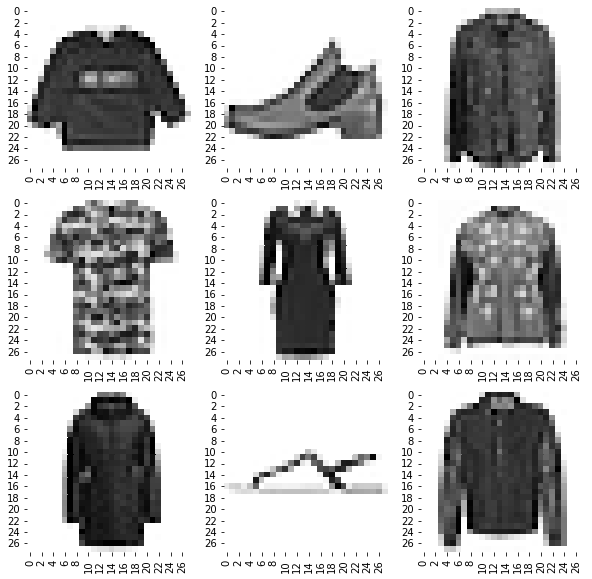

In [8]:
# visualizing some of the images

fig = plt.figure(figsize=(10,10))
for i in range(1,10):
    fig.add_subplot(3,3,i)
    sns.heatmap(np.array(data_train.iloc[i-1,1:]).reshape(28,28), cbar=False, cmap='Greys');

In [9]:
# getting the data ready for transforming

class FashionMNIST(Dataset):
    def __init__(self, data, transform=None):
        self.transform = transform
        self.labels = data.label.values
        self.images = data.iloc[:, 1:].values.astype('uint8').reshape(-1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        return img, label

In [10]:
# normalize the data and loading them for our model
data = pd.read_csv(train_file_path)
mean = np.array(data.iloc[:,1:]).flatten().mean()
std  = np.array(data.iloc[:,1:]).flatten().std()
transf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean/225,), (std/225,))])

data_test  = FashionMNIST(data_test,transform=transf)
data_train = FashionMNIST(data_train,transform=transf)

# Neural Network

In [11]:
# some global variables
INPUT_SIZE = 784
OUTPUT_SIZE = 10

In [12]:
class NNetwork(torch.nn.Module):

    def __init__(self, hidden_size: List, activation):
        super().__init__()

        self.hidden_size = hidden_size

        self.activation = activation

        modules = []
        modules.append(nn.Linear(in_features=INPUT_SIZE, out_features=hidden_size[0]))
        modules.append(self.activation)

        for i in range(len(hidden_size) - 1):
            modules.append(nn.Linear(in_features=hidden_size[i], out_features=hidden_size[i + 1]))
            modules.append(self.activation)

        modules.append(nn.Linear(in_features=hidden_size[len(hidden_size) - 1], out_features=OUTPUT_SIZE))

        self.module_list = nn.ModuleList(modules=modules)

    def forward(self, x):

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        for f in self.module_list:
            x = x.to(device)
            x = f(x)

        x = x.to(device)
        return x

In [13]:
model = None
params = []
train_accuracy = []
test_accuracy = []
loss_train = []
loss_test = []
batch_size = 30
criterion = nn.CrossEntropyLoss()
data_train = data_train
data_test = data_test



In [14]:
class FashionModel():
    """
    FashionModel is the class object that encapsulates our model
    """

    def __init__(self, data_train, data_test, batch_size: int ) -> None:
        self.model = None
        self.params = []
        self.train_accuracy = []
        self.test_accuracy = []
        self.loss_train = []
        self.loss_test = []
        self.batch_size = batch_size
        self.criterion = nn.CrossEntropyLoss()
        self.data_train = data_train
        self.data_test = data_test


    def test(self) -> None:
        """
        Evaluate a model
        """

        batch_length = len(self.test_loader)
        with torch.no_grad():
            correct = 0
            total = 0
            for batch_id, (image, label) in enumerate(self.test_loader, start=1):
                image = image.view(image.shape[0], -1)
                device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
                image = image.to(device)
                label = label.to(device)
                outputs = self.model(image)

                if (batch_id / batch_length == 1):
                    loss = self.criterion(outputs, label)
                    self.loss_test.append(loss.item())
                    print(f"Testing Loss: {loss.item():.4f}   ", end=' ')

                predicted = torch.argmax(input=outputs, dim=1)
                total += label.size(0)
                correct += (predicted == label).sum().item()

        accuracy = 100 * correct / total
        self.test_accuracy.append(accuracy)
        print(f"Testing Accuracy: {accuracy}%")

    def train(self, hidden_size: List, activation: Any, learn_rate: float, momentum: float, epochs: int) -> None:
        """
        Train a fully connected neural network classifier on a dataset of fashion images
        """
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = NNetwork(hidden_size=hidden_size, activation=activation)
        self.model.to(device)

        # Print Training Parameters
        print(f"Hidden Layers: {hidden_size}")
        print(f"Learning Rate: {learn_rate}")
        print(f"Activation:    {activation.__str__()}")
        print(f"Batch Size:    {self.batch_size}")
        print(f"Epochs:        {epochs}")
        print("------------------------------------------------------------------------------------------")

        self.train_loader = torch.utils.data.DataLoader(dataset=self.data_train, batch_size=self.batch_size, shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(dataset=self.data_test, batch_size=self.batch_size, shuffle=True)

        optimizer = torch.optim.SGD(params=self.model.parameters(), lr=learn_rate, momentum=momentum)

        for epoch in range(1, epochs + 1):
            for batch_id, (image, label) in enumerate(self.train_loader):

                image = image.view(image.shape[0],-1)
                device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
                image = image.to(device)
                label = label.to(device)

                # Forward pass
                output = self.model(image)

                loss = self.criterion(output, label)
                loss = loss.to()
                # Initializing a gradient as 0 so there is no mixing of gradient among the batches
                optimizer.zero_grad()

                # Propagating the error backward
                loss.backward()

                # Prevent Gradient Explosion
                nn.utils.clip_grad_norm_(parameters=self.model.parameters(), max_norm=2.0, norm_type=2)
                # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)

                # Optimizing the parameters
                optimizer.step()

            print(f"Epoch {epoch}/{epochs}  Training Loss: {loss.item():.4f}   ", end=' ')
            # print(f"Epoch {epoch}/{epochs}  Train Loss: {loss.item():.4f}   Train Accuracy: {accuracy:.2f}%   ", end=' ')
            self.loss_train.append(loss.item())
            self.test()

        for i in self.model.parameters():
            self.params.append(i)

#Experiment 1

In [18]:
hidden_size = [1024]
batch_size = 30
learn_rate = 0.001
activation = nn.ReLU()
momentum = 0
epochs = 2

model_1 = FashionModel(data_train=data_train, data_test=data_test, batch_size=batch_size)
model_1.train(hidden_size=hidden_size, activation=activation, learn_rate=learn_rate, momentum=momentum, epochs=epochs)

Hidden Layers: [1024]
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    30
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.9205    Testing Loss: 0.8331    Testing Accuracy: 74.27%
Epoch 2/2  Training Loss: 0.4355    Testing Loss: 0.4873    Testing Accuracy: 78.05%


#Experiment 2

In [16]:
hidden_size = [1024, 1024]
batch_size = 30
learn_rate = 0.001
activation = nn.ReLU()
momentum = 0
epochs = 2

model_2 = FashionModel(data_train=data_train, data_test=data_test, batch_size=batch_size)
model_2.train(hidden_size=hidden_size, activation=activation, learn_rate=learn_rate, momentum=momentum, epochs=epochs)

Hidden Layers: [1024, 1024]
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    30
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 1.0295    Testing Loss: 0.7072    Testing Accuracy: 72.53%
Epoch 2/2  Training Loss: 0.6597    Testing Loss: 0.7993    Testing Accuracy: 75.76%


#Visualization

In [19]:
# %matplotlib inline
# %matplotlib notebook
# %matplotlib widget

# plt.rcParams['figure.figsize'] = [25, 10]
plt.rcParams['figure.figsize'] = [25, 5]


def display_model_visuals(model, title):

    # Plot Accuracy 
    plt.subplot(1,3,1)
    param_title = f"Hidden: {hidden_size}, batch: {model.batch_size}, η: {learn_rate}, φ: {activation.__str__()}"
    plt.plot(np.arange(epochs), model.test_accuracy, label='Test Accuracy')
    plt.title(f"{title}: Accuracy\n{param_title}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.xticks(np.arange(len(model.test_accuracy)), np.arange(1, len(model.test_accuracy) + 1))
    plt.legend();

    # Plot Cross-Entropy
    plt.subplot(1,3,2)
    param_title = f"Hidden: {hidden_size}, batch: {model.batch_size}, η: {learn_rate}, φ: {activation.__str__()}"
    plt.plot(np.arange(epochs), model.loss_train, label='Train Loss')
    plt.plot(np.arange(epochs), model.loss_test, label='Test Loss')
    plt.title(f"{title}: Cross Entropy Loss\n{param_title}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xticks(np.arange(len(model.loss_test)), np.arange(1, len(model_a.loss_test) + 1))
    plt.legend();

    # Create Confusion Matrix
    nb_classes = 10
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (image, classes) in enumerate(model.test_loader):
            image = image.view(image.shape[0], -1)
            outputs = model.model(image)
            _, preds = torch.max(outputs, dim=1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    cols = ["T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag",
            "Ankle Boot"]
    plt.subplot(1,3,3)
    plt.title(f"{title}: Confusion Matrix\n{param_title}")
    sns.heatmap(pd.DataFrame(np.array(confusion_matrix), columns=cols, index=cols), cmap='Greys', annot=True, fmt='g');
    
    plt.show()

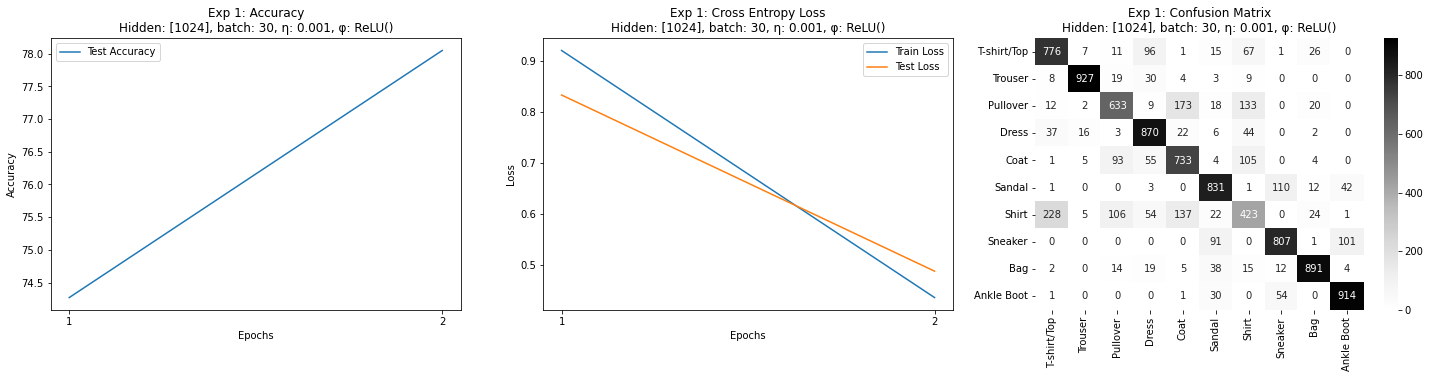

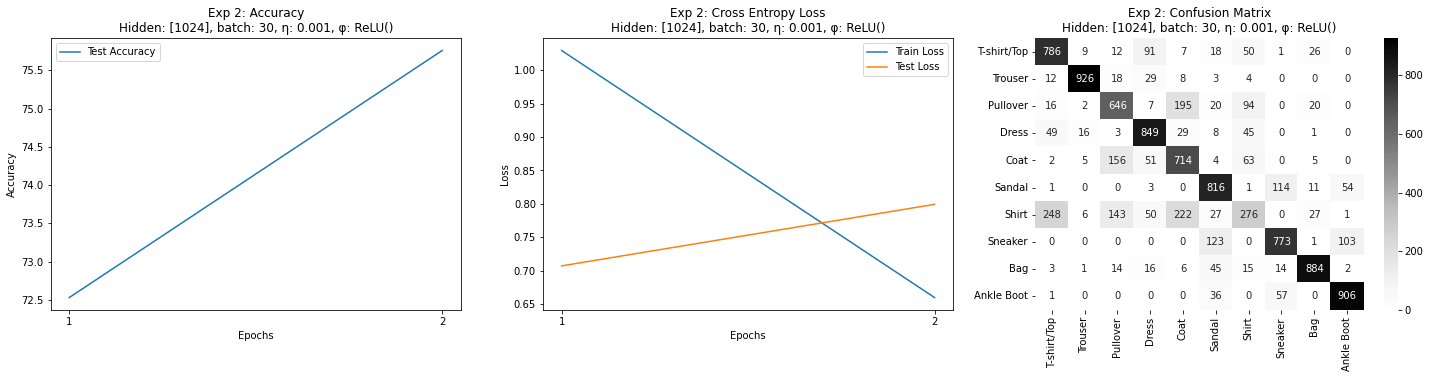

In [20]:
display_model_visuals(model_1, "Exp 1");
display_model_visuals(model_2, "Exp 2")